### Pruning point sources from the COSMOS catalog (25.2 mag limit)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from os.path import expanduser
from wlenet import config
from wlenet.misc.gpu import avoid_gpu_in_this_process; avoid_gpu_in_this_process()

from multiprocessing import Pool, cpu_count
import astropy.io.fits as pyfits
from wlenet.misc.utils import crop_center
from wlenet.misc.figures import show_stamps, abline

In [2]:
save_valid_indices = True
save_figures = True

In [3]:
num_image_files = 88
rgc_path = '~/datasets/wlenet/cosmos/COSMOS_25.2_training_sample/real_galaxy_catalog_25.2.fits'
rgc_dir, rgc_file = os.path.split(os.path.expanduser(rgc_path))
fits_file = os.path.splitext(rgc_file)[0] + '_fits.fits'
mask_info_file = 'real_galaxy_mask_info.fits'
selection_info_file = 'real_galaxy_selection_info.fits'
rgc_catalog = pyfits.getdata(os.path.join(rgc_dir, rgc_file))
fit_catalog = pyfits.getdata(os.path.join(rgc_dir, fits_file))

In [4]:
def get_galaxy_images(galaxy_image_filename):
    
    image_path = rgc_dir + '/' + galaxy_image_filename
    f = pyfits.open(image_path, memmap=True)
    gal_ims = [f[i].data for i in range(len(f))]
    return gal_ims

In [5]:
mp_pool_size = cpu_count() - 1
pool = Pool(mp_pool_size)
galaxy_image_filenames = ['real_galaxy_images_25.2_n%d.fits' % (i+1) for i in range(num_image_files)]
file_gal_ims = pool.map(get_galaxy_images, galaxy_image_filenames)
name_to_num = dict(zip(galaxy_image_filenames, range(num_image_files)))

In [6]:
stamps = [file_gal_ims[name_to_num[rgc_catalog['GAL_FILENAME'][i]]][rgc_catalog['GAL_HDU'][i]] for i in range(rgc_catalog.size)]

In [7]:
mu_max = np.array([np.max(stamp) for stamp in stamps])
mu_max[mu_max < 0] = np.nan
mu_max = -2.5*np.log10(mu_max)

In [8]:
mags = fit_catalog['mag_auto']
half_light_radii = fit_catalog['flux_radius']

In [9]:
hlr_min = 0
hlr_max = 4.5
mags_min = 15
mags_max = 21.6
mag_delta_left = 0.4
mag_delta_right = 0.4

In [10]:
pt_srcs_hlr = (half_light_radii >= hlr_min) * (half_light_radii <= hlr_max) * (mags > mags_min) * (mags < mags_max)

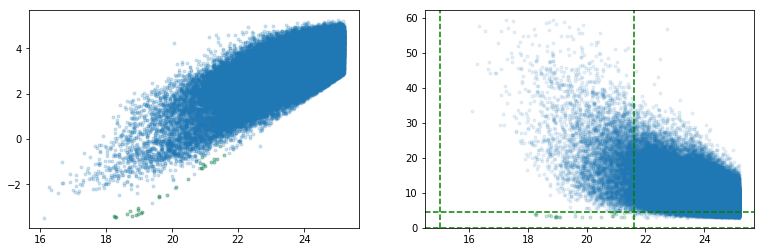

In [11]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.plot(mags, mu_max, '.', alpha=0.2)
plt.plot(mags[pt_srcs_hlr], mu_max[pt_srcs_hlr], 'g.', alpha=0.2)

plt.subplot(1,2,2)
plt.plot(mags, half_light_radii, '.', alpha=0.1)
plt.plot(mags[pt_srcs_hlr], half_light_radii[pt_srcs_hlr], 'g.', alpha=0.1)
plt.axhline(y=hlr_min, linestyle='--', color='green')
plt.axhline(y=hlr_max, linestyle='--', color='green')
plt.axvline(x=mags_min, linestyle='--', color='green')
plt.axvline(x=mags_max, linestyle='--', color='green')

In [12]:
fit = np.polyfit(mags[pt_srcs_hlr], mu_max[pt_srcs_hlr], 1)
mu_max_max = np.max(mu_max[pt_srcs_hlr])

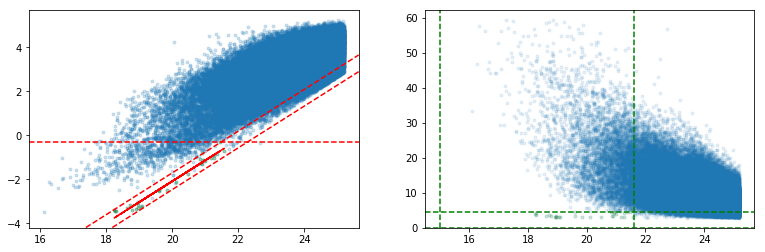

In [13]:
plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
plt.plot(mags, mu_max, '.', alpha=0.2)
plt.plot(mags[pt_srcs_hlr], mu_max[pt_srcs_hlr], 'g.', alpha=0.2)

plt.plot(mags[pt_srcs_hlr], fit[0]*mags[pt_srcs_hlr] + fit[1], 'r--')
abline(fit[0], fit[1] + mag_delta_left*fit[0], 'r--')
abline(fit[0], fit[1] - mag_delta_right*fit[0], 'r--')
plt.axhline(y=mu_max_max, linestyle='--', color='red')

plt.subplot(1,2,2)
plt.plot(mags, half_light_radii, '.', alpha=0.1)
plt.plot(mags[pt_srcs_hlr], half_light_radii[pt_srcs_hlr], 'g.', alpha=0.1)
plt.axhline(y=hlr_min, linestyle='--', color='green')
plt.axhline(y=hlr_max, linestyle='--', color='green')
plt.axvline(x=mags_min, linestyle='--', color='green')
plt.axvline(x=mags_max, linestyle='--', color='green')

In [14]:
mag_lim_max = -fit[1]/fit[0] + mu_max/fit[0] + mag_delta_right
mag_lim_min = -fit[1]/fit[0] + mu_max/fit[0] - mag_delta_left
pt_srcs_mu_max = (mu_max < mu_max_max) * (mags < mag_lim_max) * (mags > mag_lim_min)

pt_srcs = pt_srcs_mu_max + pt_srcs_hlr
bad_srcs = mags > mag_lim_max

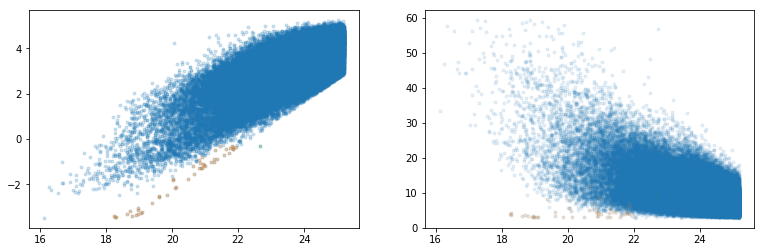

In [15]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.plot(mags, mu_max, '.', alpha=0.2)
plt.plot(mags[pt_srcs], mu_max[pt_srcs], '.', alpha=0.2)
plt.plot(mags[bad_srcs], mu_max[bad_srcs], '.', alpha=0.2)

plt.subplot(1,2,2)
plt.plot(mags, half_light_radii, '.', alpha=0.1)
plt.plot(mags[pt_srcs], half_light_radii[pt_srcs], '.', alpha=0.1)
plt.plot(mags[bad_srcs], half_light_radii[bad_srcs], '.', alpha=0.1)

In [16]:
stamps_cropped = np.array([crop_center(stamp, 100, 100) for stamp in stamps])

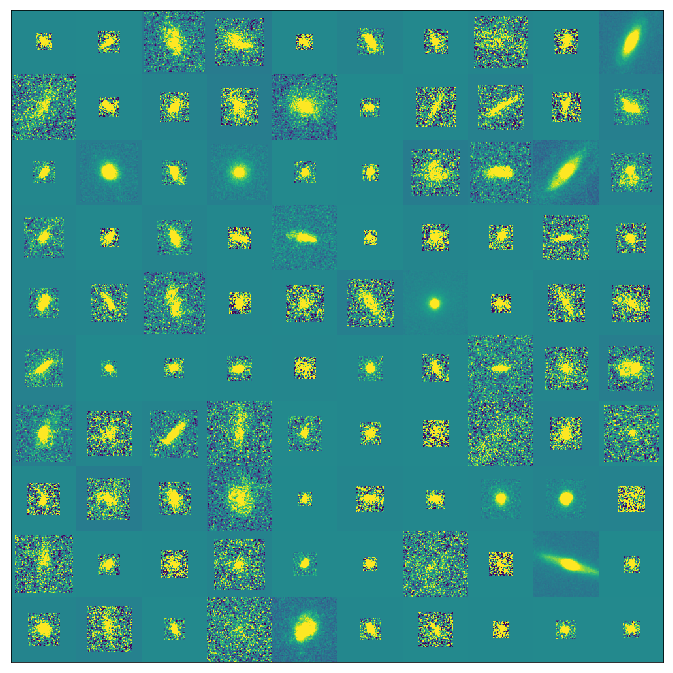

In [17]:
show_stamps(stamps_cropped, num_pages=1)

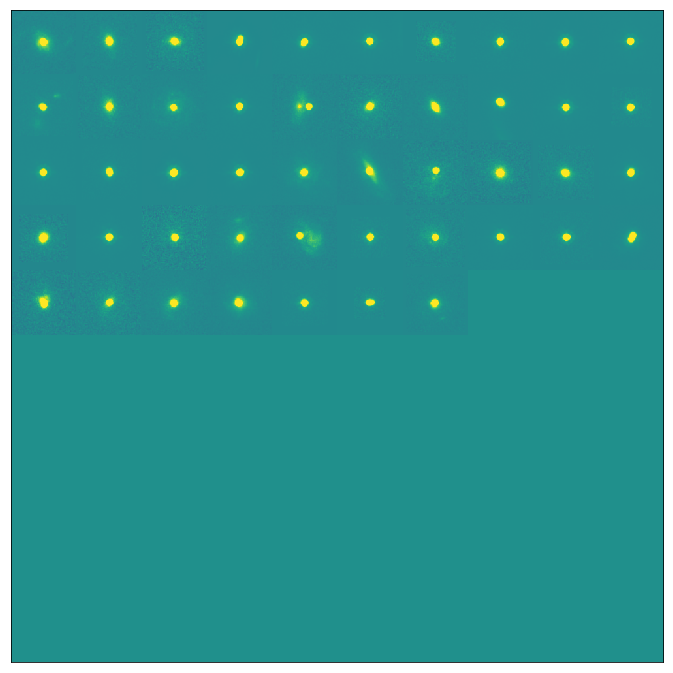

In [18]:
show_stamps(stamps_cropped[pt_srcs, ...])

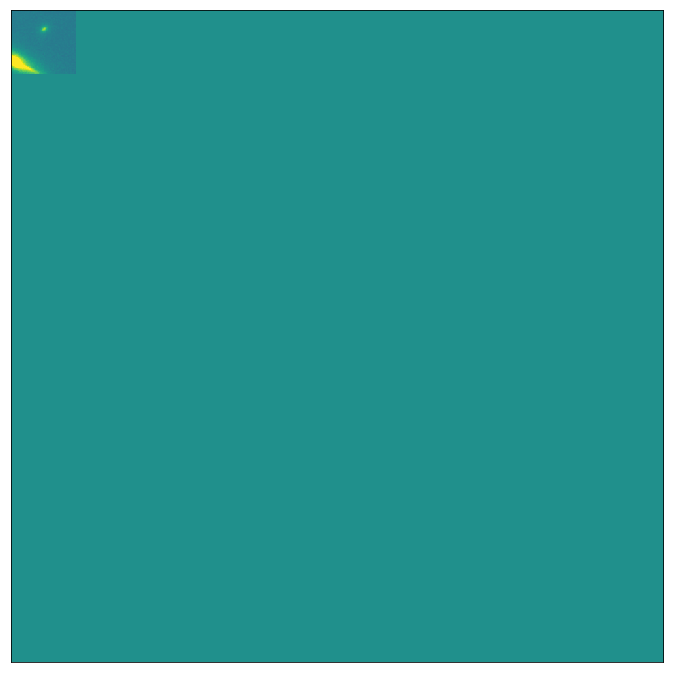

In [19]:
show_stamps(stamps_cropped[bad_srcs, ...])

In [20]:
if save_valid_indices:
    valid_indices = np.where(~(pt_srcs + bad_srcs))[0]
    valid_index_path = expanduser(config['calibration_path'] + '/cosmos_valid_indices.npy')
    np.save(valid_index_path, valid_indices)

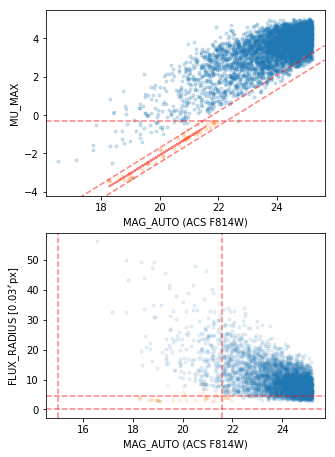

In [21]:
plt.figure(figsize=(5, 7.5))

plt.subplot(2,1,1)

sub_inds = np.random.rand(mags.shape[0]) < 0.05

plt.plot(mags[sub_inds], mu_max[sub_inds], '.', alpha=0.2)
plt.plot(mags[pt_srcs], mu_max[pt_srcs], '.', alpha=0.2)
plt.plot(mags[bad_srcs], mu_max[bad_srcs], '.', alpha=0.2)

plt.plot(mags[pt_srcs_hlr], fit[0]*mags[pt_srcs_hlr] + fit[1], 'r--', alpha=0.5)
abline(fit[0], fit[1] + mag_delta_left*fit[0], 'r--', alpha=0.5)
abline(fit[0], fit[1] - mag_delta_right*fit[0], 'r--', alpha=0.5)
plt.axhline(y=mu_max_max, linestyle='--', color='red', alpha=0.5)

plt.xlabel('MAG_AUTO (ACS F814W)')
plt.ylabel('MU_MAX')

plt.subplot(2,1,2)
plt.plot(mags[sub_inds], half_light_radii[sub_inds], '.', alpha=0.1)
plt.plot(mags[pt_srcs], half_light_radii[pt_srcs], '.', alpha=0.1)
plt.plot(mags[bad_srcs], half_light_radii[bad_srcs], '.', alpha=0.1)

plt.axhline(y=hlr_min, linestyle='--', color='red', alpha=0.5)
plt.axhline(y=hlr_max, linestyle='--', color='red', alpha=0.5)
plt.axvline(x=mags_min, linestyle='--', color='red', alpha=0.5)
plt.axvline(x=mags_max, linestyle='--', color='red', alpha=0.5)

plt.xlabel('MAG_AUTO (ACS F814W)')
plt.ylabel("FLUX_RADIUS [$0.03''$px]");

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/calibration/point_sources_cosmos.pdf')
    plt.savefig(fig_path)

Point sources (orange) and false detections (green) identified in the COSMOS source catalog. A random 5% subset of the unmasked sources is shown here.